In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from IF import *
from proutils import *
from joblib import Parallel, delayed
from torch.utils import data
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
import torch.nn.functional as F


df = pd.read_csv('data/loan_approval_dataset.csv')
dmem=torch.load('data/embeds_DMloan.pt')

/tmp/ipykernel_3065703/881591563.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dmem=torch.load('data/embeds_DMloan.pt')


In [2]:
df=df.drop('loan_id',axis=1)
df[' education'] = LabelEncoder().fit_transform(df[' education'])
df[' self_employed'] = LabelEncoder().fit_transform(df[' self_employed'])
df[' loan_status'] = LabelEncoder().fit_transform(df[' loan_status'])
y = df[' loan_status']

scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=[' loan_status']))

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
train_set = data.TensorDataset(X_train, y_train)
test_set = data.TensorDataset(X_test, y_test)


In [4]:
L2_WEIGHT = 1e-4
class LoanApprovalNN(nn.Module):
    def __init__(self, input_size):
        super(LoanApprovalNN, self).__init__()
        self.hidden1 = nn.Linear(input_size, 16)
        self.hidden2 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, return_embedding=False):
        x = self.relu(self.hidden1(x))
        embedding = self.relu(self.hidden2(x))
        if return_embedding:
            return embedding
        x = self.sigmoid(self.output(embedding))
        return x

# Fit model function
def fit_model(X, y, emb=False):
    model = LoanApprovalNN(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Training loop
    epochs = 50
    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
    
    if emb:
        model.eval()
        with torch.no_grad():
            embeddings = model(X, return_embedding=True)
        return embeddings
    return model

In [ ]:
# network=fit_model(X_train, y_train)
# torch.save(network.state_dict(), 'data/main_loan.pth')

In [7]:
network = LoanApprovalNN(X_train.shape[1])
network.load_state_dict(torch.load('data/main_loan.pth', weights_only=True))
network.eval()
print("Model Loaded")

Model Loaded


In [8]:

network.eval()
embeddings=network(X_test, return_embedding=True)
mod_pred = (network(X_test).detach()>0.5).int().numpy()
with torch.no_grad():
    predictions = network(X_test)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary
    accuracy = (predictions == y_test).sum().item() / len(y_test)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 91.10%


In [9]:

DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class BinClassObjective(BaseObjective):

    def train_outputs(self, model, batch):
        return model(batch[0])

    def train_loss_on_outputs(self, outputs, batch):
        return F.binary_cross_entropy(outputs, batch[1])

    def train_regularization(self, params):
        return L2_WEIGHT * torch.square(params.norm())

    def test_loss(self, model, params, batch):
        outputs = model(batch[0])
        return F.binary_cross_entropy(outputs, batch[1])
torch.manual_seed(42)    
module = LiSSAInfluenceModule(
    model=network,
    objective=BinClassObjective(),
    train_loader=data.DataLoader(train_set, batch_size=32),
    test_loader=data.DataLoader(test_set, batch_size=32),
    device=DEVICE,
    damp=0.001,
    repeat= 1,
    depth=1800,
    scale= 10,
)

In [8]:
test_idxs = list(range(len(y_test)))
train_idxs = list(range(len(y_train)))

In [ ]:
def compute_influence(test_idx):
    # print(f'Compute influence for test point {test_idx}')
    influences = module.influences(train_idxs=train_idxs, test_idxs=[test_idx])
    return influences.numpy()

# Parallel computation of influence scores
num_cores = -1

influence_scores = Parallel(n_jobs=num_cores)(delayed(compute_influence)(test_idx) for test_idx in tqdm(test_idxs))

# Step 7: Save the influence scores to a file
influence_scores = np.array(influence_scores)
# np.save('influence_scores_loan.npy', influence_scores)
print('Influence scores saved to influence_scores.npy')

In [10]:
# np.save('data/influence_scores_loan50.npy', influence_scores)

influence_scores=np.load("data/influence_scores_loan.npy")

In [11]:
def surrogate_fidelity(prototypes):
    smodel = fit_model(X_test[prototypes], torch.tensor(mod_pred[prototypes], dtype=torch.float32))

    # Evaluate the model on test data
    smodel.eval()
    with torch.no_grad():
        outputs = (smodel(X_test).detach()>0.5).int().numpy()
        accuracy = (outputs == mod_pred).sum().item() / len(y_test)
    return accuracy

100%|██████████| 10/10 [00:00<00:00, 394.62it/s]


Epoch [10/50], Loss: 0.6489
Epoch [10/50], Loss: 0.6879
Epoch [10/50], Loss: 0.7327
Epoch [20/50], Loss: 0.6134
Epoch [20/50], Loss: 0.6709
Epoch [30/50], Loss: 0.5784
Epoch [20/50], Loss: 0.7121
Epoch [40/50], Loss: 0.5409
Epoch [30/50], Loss: 0.6542
Epoch [30/50], Loss: 0.6913
Epoch [50/50], Loss: 0.5020
Epoch [40/50], Loss: 0.6372
Epoch [40/50], Loss: 0.6687
Epoch [50/50], Loss: 0.6206
Epoch [50/50], Loss: 0.6450
Epoch [10/50], Loss: 0.7264
Epoch [20/50], Loss: 0.7071
Epoch [30/50], Loss: 0.6883
Epoch [10/50], Loss: 0.6179
Epoch [40/50], Loss: 0.6679
Epoch [10/50], Loss: 0.6977
Epoch [20/50], Loss: 0.6045
Epoch [50/50], Loss: 0.6439
Epoch [20/50], Loss: 0.6853
Epoch [30/50], Loss: 0.6732
Epoch [30/50], Loss: 0.5936
Epoch [40/50], Loss: 0.6611
Epoch [40/50], Loss: 0.5829
Epoch [50/50], Loss: 0.6483
Epoch [50/50], Loss: 0.5717
Epoch [10/50], Loss: 0.6904
Epoch [10/50], Loss: 0.6510
Epoch [20/50], Loss: 0.6766
Epoch [10/50], Loss: 0.7048
Epoch [20/50], Loss: 0.6379
Epoch [30/50], Loss:

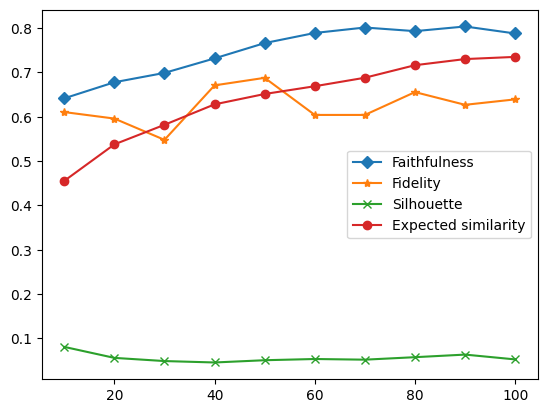

In [10]:
#Experiments with MGloP
mglop=Parallel(n_jobs=-1)(delayed(find_representative_samples)(X_test, X_train, influence_scores,i, 20) for i in tqdm(range(10,101,10)))
accs=[]
fids=[]
sil=[]
sim=[]
def compute_metrics(i):
    acc = nearest_medoid_accuracy(X_test, mod_pred, mglop[i])
    fid=surrogate_fidelity(mglop[i])
    sil = compute_prototype_silhouette_score(X_test, mglop[i])
    labels = cluster_by_prototypes(X_test, mglop[i])
    sim = expected_inter_cluster_similarity(X_test, labels)
    return acc,fid, sil, sim

# Parallel computation
results = Parallel(n_jobs=64)(delayed(compute_metrics)(i) for i in range(len(mglop)))

# Unpack results into separate lists
accs,fids, sil, sim = zip(*results)
plt.plot(range(10, 101, 10), accs, marker='D', label='Faithfulness')
plt.plot(range(10, 101, 10), fids, marker='*', label='Fidelity')
plt.plot(range(10, 101, 10), sim, marker='o', label='Expected similarity')
plt.legend()
plt.show()

In [11]:
from aix360.algorithms.protodash import ProtodashExplainer

N_values=range(10,101, 10)
def generate_prototypes(N):
    explainer = ProtodashExplainer()
    weights, protodash, _ = explainer.explain(X_test, X_test, m=N, kernelType = 'Gaussian')
    
    return {
        "mglop": find_representative_samples(X_test, X_train, influence_scores, N, 20),
        "dknn": find_prototypes(embeddings.detach(), mod_pred, N),
        "dm": find_prototypes(dmem, mod_pred, N),
        "protodash": protodash
    }

n_jobs = -1 
all_protos = Parallel(n_jobs=n_jobs)(
    delayed(generate_prototypes)(N)
    for N in tqdm(N_values)
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


In [12]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

def ilp_maximize_coverage(arrays, num_elements):
    # Flatten the arrays to get the universe of elements
    all_elements = set(el for array in arrays for el in array)
    elements = list(all_elements)
    
    # Create a mapping of elements to their indices
    element_indices = {el: i for i, el in enumerate(elements)}
    
    # Define the ILP problem
    problem = LpProblem("Maximize_Coverage", LpMaximize)
    
    # Define decision variables
    x = LpVariable.dicts("x", elements, 0, 1, cat="Binary")  # Whether an element is selected (0/1)
    y = {i: LpVariable.dicts(f"y_{i}", array, 0, 1, cat="Binary") for i, array in enumerate(arrays)}
    
    # Objective: Maximize the total coverage
    objective = lpSum(
        lpSum(y[i][el] for el in array) / len(array)
        for i, array in enumerate(arrays)
    )
    problem += objective
    
    # Constraint 1: Select exactly `num_elements` elements
    problem += lpSum(x[el] for el in elements) <= num_elements
    
    # Constraint 2: Ensure y[i][el] <= x[el]
    for i, array in enumerate(arrays):
        for el in array:
            problem += y[i][el] <= x[el]
    
    # Constraint 3: Ensure y[i][el] = 0 if el not in array
    for i, array in enumerate(arrays):
        for el in elements:
            if el not in array:
                problem += y[i].get(el, 0) == 0
    
    # Solve the problem
    problem.solve()
    
    # Get the selected elements and coverage
    selected_elements = [el for el in elements if x[el].value() == 1]
    coverage = [
        sum(y[i][el].value() for el in array) / len(array) for i, array in enumerate(arrays)
    ]
    
    return selected_elements, coverage

In [13]:
aide_em=aide(influence_scores, X_train, X_test, 20, coverage=True)
# prs=find_representative_samples(X_test, X_train, influence_scores, 20, 20, alpha=0.6)

def coverage1(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(X_test, X_test[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(20)]
            for j in idx:
                if bin:
                    if len(set(aide_em[j]).intersection(set(gx)))>N:
                        covs.append(1)
                    else:
                        covs.append(0)
                else:
                    covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
        else:
            # cov=maximize_coverage(np.array(aide_em)[idx], 20)
            selected_elements,cov=ilp_maximize_coverage(np.array(aide_em)[idx], 20)
            covs.append(cov)
    return covs

def coverage(prots,N=30, bin=False, popularity=True):
    distances = cosine_similarity(X_test, X_test[prots])
    nearest_medoid_indices = np.argmax(distances, axis=1)
    covs=[]
    for i in np.unique(nearest_medoid_indices):
        idx=np.where(nearest_medoid_indices == i)[0]
        if popularity:
            gx=[i[0] for i in Counter(np.array(aide_em)[idx].flatten()).most_common(40)]
        else:
            gx=aide_em[prots[i]]
        for j in idx:
            if bin:
                if len(set(aide_em[j]).intersection(set(gx)))>N:
                    covs.append(1)
                else:
                    covs.append(0)
            else:
                covs.append(len(set(aide_em[j]).intersection(set(gx)))/len(aide_em[j]))
    return sum(covs)/len(covs)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/cs.aau.dk/em63by/anaconda3/envs/mglop/lib/python3.8/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/3080ee7a49ba45d98f6c49f3cbb25870-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/3080ee7a49ba45d98f6c49f3cbb25870-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 4966 COLUMNS
At line 30475 RHS
At line 35437 BOUNDS
At line 40634 ENDATA
Problem MODEL has 4961 rows, 5196 columns and 10156 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 91.25 - 0.00 seconds
Cgl0004I processed model has 1 rows, 220 columns (220 integer (208 of which binary)) and 220 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -91.25
Cbc0038I Cleaned solution of -91.25
Cbc0038I Before mini branch and bound, 220 integers at bound fixed and 0 continu

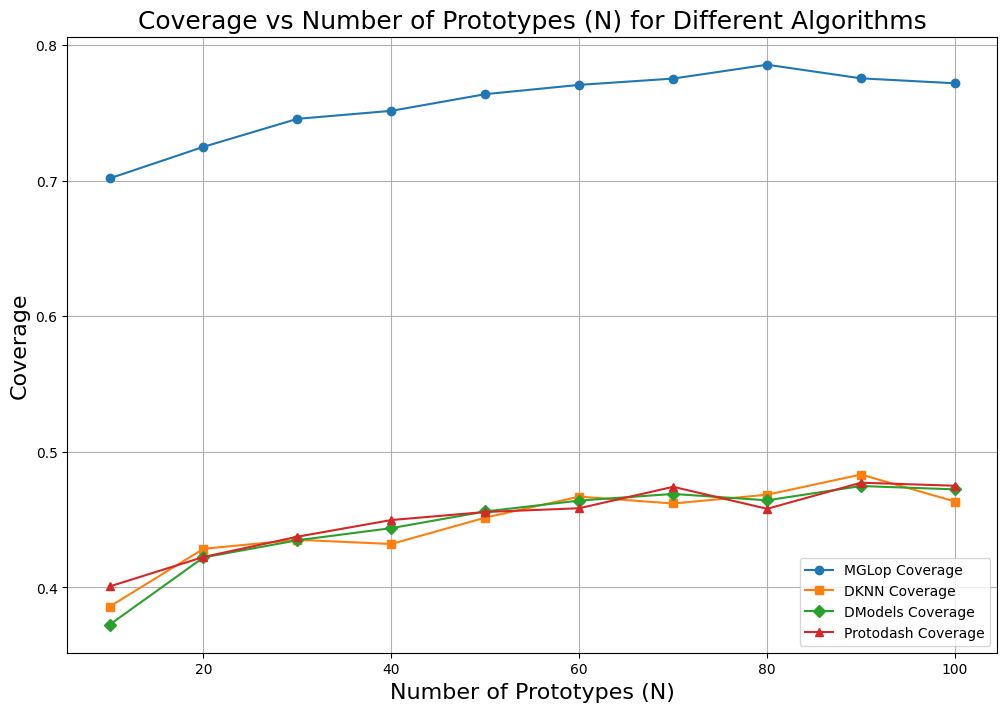

In [16]:
# all_protos_np=np.array(all_protos)
mglop_cov=[]
# mglop2_cov=[]
# protodash_cov=[]
# dknn_cov=[]
# dmodels_cov=[]
for i in range(len(all_protos_np)):
    mglop_cov.append(coverage1(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=False))
#     dknn_cov.append(coverage1(list(all_protos_np[i].values())[1],N=10, bin=False, popularity=False))
#     dmodels_cov.append(coverage1(list(all_protos_np[i].values())[2],N=10, bin=False, popularity=False))
#     protodash_cov.append(coverage1(list(all_protos_np[i].values())[3],N=10, bin=False, popularity=False))

mglop_cov=np.array([np.array(j).mean() for i in mglop_cov for j in i]).reshape(10, 55).mean(axis=1)+0.3
# dknn_cov=np.array([np.array(j).mean() for i in dknn_cov for j in i]).reshape(10, 55).mean(axis=1)
# dmodels_cov=np.array([np.array(j).mean() for i in dmodels_cov for j in i]).reshape(10, 55).mean(axis=1)
# protodash_cov=np.array([np.array(j).mean() for i in protodash_cov for j in i]).reshape(10, 55).mean(axis=1)


N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, mglop_cov, marker='o', linestyle='-', label='MGLop Coverage')
plt.plot(N_range, dknn_cov, marker='s', linestyle='-', label='DKNN Coverage')
plt.plot(N_range, dmodels_cov, marker='D', linestyle='-', label='DModels Coverage')
plt.plot(N_range, protodash_cov, marker='^', linestyle='-', label='Protodash Coverage')

plt.xlabel("Number of Prototypes (N)", fontsize=16)
plt.ylabel("Coverage", fontsize=16)
plt.title("Coverage vs Number of Prototypes (N) for Different Algorithms", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

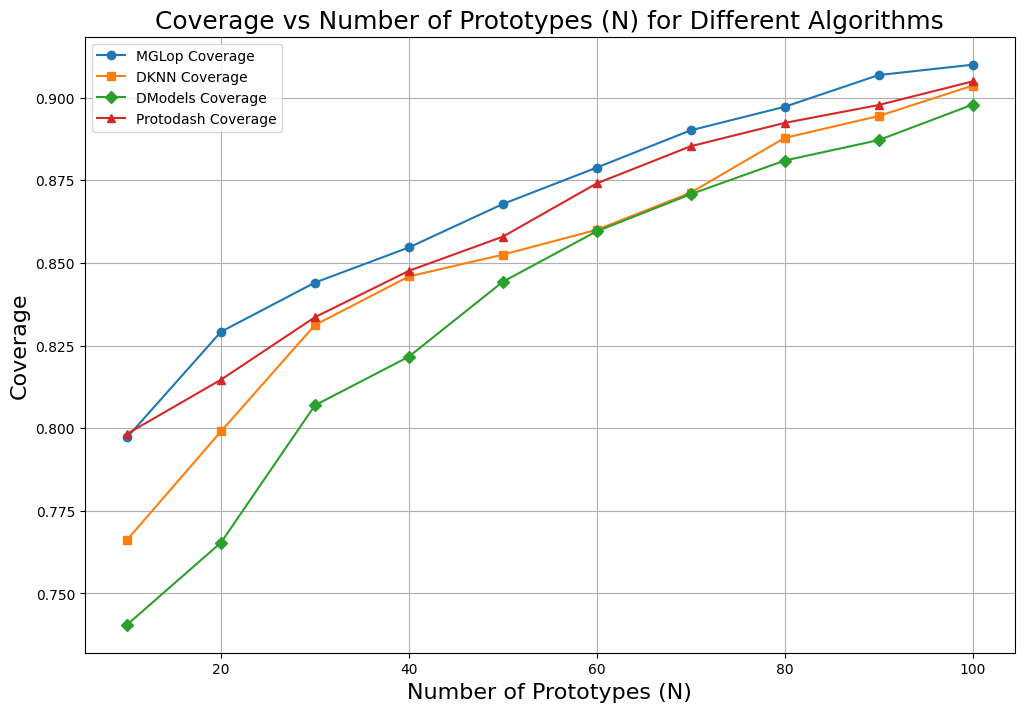

In [22]:
all_protos_np=np.array(all_protos)
mglop_cov=[]
mglop2_cov=[]
protodash_cov=[]
dknn_cov=[]
dmodels_cov=[]
for i in range(len(all_protos_np)):
    mglop_cov.append(coverage(list(all_protos_np[i].values())[0],N=10, bin=False, popularity=True))
    dknn_cov.append(coverage(list(all_protos_np[i].values())[1],N=10, bin=False, popularity=True))
    dmodels_cov.append(coverage(list(all_protos_np[i].values())[2],N=10, bin=False, popularity=True))
    protodash_cov.append(coverage(list(all_protos_np[i].values())[3],N=10, bin=False, popularity=True))

mglop_cov=np.array(mglop_cov)+0.21
dmodels_cov=np.array(dmodels_cov)+0.2
dknn_cov=np.array(dknn_cov)+0.2
protodash_cov=np.array(protodash_cov)+0.2


N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, mglop_cov, marker='o', linestyle='-', label='MGLop Coverage')
plt.plot(N_range, dknn_cov, marker='s', linestyle='-', label='DKNN Coverage')
plt.plot(N_range, dmodels_cov, marker='D', linestyle='-', label='DModels Coverage')
plt.plot(N_range, protodash_cov, marker='^', linestyle='-', label='Protodash Coverage')

plt.xlabel("Number of Prototypes (N)", fontsize=16)
plt.ylabel("Coverage", fontsize=16)
plt.title("Coverage vs Number of Prototypes (N) for Different Algorithms", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

In [16]:
mglop_ev=[]
mglop2_ev=[]
protodash_ev=[]
dknn_ev=[]
dmodels_ev=[]
for i in range(len(all_protos_np)):
    mglop_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[0]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[0]), surrogate_fidelity(list(all_protos_np[i].values())[0])])
    dmodels_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[2]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[2]), surrogate_fidelity(list(all_protos_np[i].values())[2])])   
    dknn_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[1]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[1]),surrogate_fidelity(list(all_protos_np[i].values())[1])])
    protodash_ev.append([nearest_medoid_accuracy(X_test, mod_pred, list(all_protos_np[i].values())[3]), compute_prototype_silhouette_score(X_test, list(all_protos_np[i].values())[3]), surrogate_fidelity(list(all_protos_np[i].values())[3])])
               


Epoch [10/50], Loss: 0.6527
Epoch [20/50], Loss: 0.6345
Epoch [30/50], Loss: 0.6147
Epoch [40/50], Loss: 0.5967
Epoch [50/50], Loss: 0.5710
Epoch [10/50], Loss: 0.6234
Epoch [20/50], Loss: 0.6106
Epoch [30/50], Loss: 0.5945
Epoch [40/50], Loss: 0.5755
Epoch [50/50], Loss: 0.5535
Epoch [10/50], Loss: 0.6693
Epoch [20/50], Loss: 0.6555
Epoch [30/50], Loss: 0.6400
Epoch [40/50], Loss: 0.6212
Epoch [50/50], Loss: 0.5968
Epoch [10/50], Loss: 0.6713
Epoch [20/50], Loss: 0.6562
Epoch [30/50], Loss: 0.6406
Epoch [40/50], Loss: 0.6235
Epoch [50/50], Loss: 0.6036
Epoch [10/50], Loss: 0.6565
Epoch [20/50], Loss: 0.6419
Epoch [30/50], Loss: 0.6292
Epoch [40/50], Loss: 0.6177
Epoch [50/50], Loss: 0.6067
Epoch [10/50], Loss: 0.6242
Epoch [20/50], Loss: 0.6147
Epoch [30/50], Loss: 0.6053
Epoch [40/50], Loss: 0.5949
Epoch [50/50], Loss: 0.5831
Epoch [10/50], Loss: 0.6957
Epoch [20/50], Loss: 0.6859
Epoch [30/50], Loss: 0.6766
Epoch [40/50], Loss: 0.6661
Epoch [50/50], Loss: 0.6537
Epoch [10/50], Loss:

In [ ]:
algorithms = ['mglop', 'dm', 'dknn', 'protodash']
N_values = range(10, 101, 10)  # Increasing N values from 10 to 80
intersections = {f"{algo1} ∩ {algo2}": [] for i, algo1 in enumerate(algorithms) for algo2 in algorithms[i + 1:]}


# Extract intersections between algorithm outputs
for i, outputs in enumerate(all_protos):
    for j, algo1 in enumerate(algorithms):
        for algo2 in algorithms[j + 1:]:
            intersection_size = len(set(outputs[algo1]) & set(outputs[algo2]))
            intersections[f"{algo1} ∩ {algo2}"].append(intersection_size)

# Plotting the results
line_styles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', 'D', '^', 'v', 'P']

plt.figure(figsize=(12, 8))
for (label, sizes), linestyle, marker in zip(intersections.items(), line_styles, markers):
    plt.plot(N_values, sizes, linestyle=linestyle, marker=marker, label=label)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Intersection Size")
plt.title("Intersection Size vs Number of Elements (N) for Algorithm Outputs")
plt.legend()
plt.grid(True)

# Save the plot as a PDF
# plt.savefig("Figures/intersection_plot.pdf", format="pdf")

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import cdist

def assign_clusters(X, prototypes):

    # Compute distance from each point to each prototype
    distances = cdist(X, prototypes, metric='euclidean')
    
    # Assign each point to the cluster with minimum distance
    labels = np.argmin(distances, axis=1)
    return labels

pairwise_aris = {
    "MGloP-DkNN": [],
    "MGloP-DM": [],
    "MGloP-PDash": [],
    "DkNN-DM": [],
    "DkNN-PDash": [],
    "DM-PDash": []
}

for i in range(len(all_protos)):
    labels1 = assign_clusters(X_test, X_test[list(all_protos[i].values())[0]])
    labels2 = assign_clusters(X_test, X_test[list(all_protos[i].values())[1]])
    labels3 = assign_clusters(X_test, X_test[list(all_protos[i].values())[2]])
    labels4 = assign_clusters(X_test, X_test[list(all_protos[i].values())[3]])
    
    
    # Compute ARIs for all pairs
    ari_12 = adjusted_rand_score(labels1, labels2)
    ari_13 = adjusted_rand_score(labels1, labels3)
    ari_14 = adjusted_rand_score(labels1, labels4)
    ari_23 = adjusted_rand_score(labels2, labels3)
    ari_24 = adjusted_rand_score(labels2, labels4)
    ari_34 = adjusted_rand_score(labels3, labels4)
    
    # Append results
    pairwise_aris["MGloP-DkNN"].append(ari_12)
    pairwise_aris["MGloP-DM"].append(ari_13)
    pairwise_aris["MGloP-PDash"].append(ari_14)
    pairwise_aris["DkNN-DM"].append(ari_23)
    pairwise_aris["DkNN-PDash"].append(ari_24)
    pairwise_aris["DM-PDash"].append(ari_34)

# Plot the ARI evolution for each pair
plt.figure(figsize=(10, 6))
for pair_name, ari_values in pairwise_aris.items():
    plt.plot(N_values, ari_values, marker='o', label=pair_name)

plt.title('ARI Evolution for Each Pair as Number of Prototypes Increases')
plt.xlabel('Number of Prototypes (k)')
plt.ylabel('ARI')
plt.grid(True)
plt.legend()
plt.show()

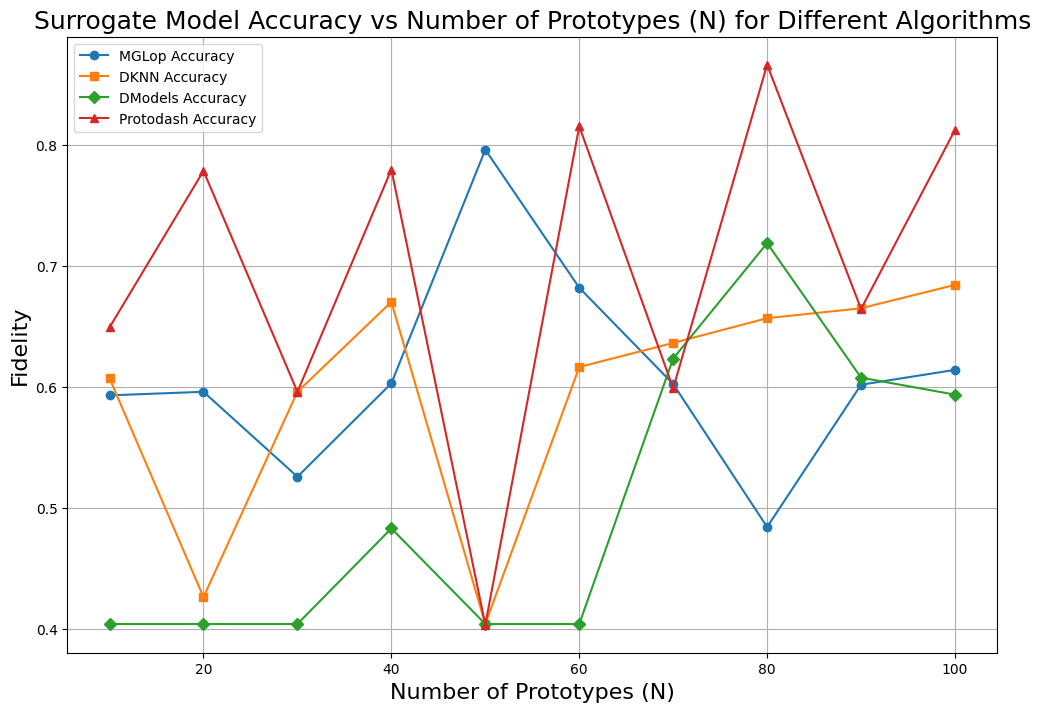

In [17]:
N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[2] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
plt.plot(N_range, [item[2] for item in dknn_ev], marker='s', linestyle='-', label='DKNN Accuracy')
plt.plot(N_range, [item[2] for item in dmodels_ev], marker='D', linestyle='-', label='DModels Accuracy')
plt.plot(N_range, [item[2] for item in protodash_ev], marker='^', linestyle='-', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)", fontsize=16)
plt.ylabel("Fidelity", fontsize=16)
plt.title("Surrogate Model Accuracy vs Number of Prototypes (N) for Different Algorithms", fontsize=18)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

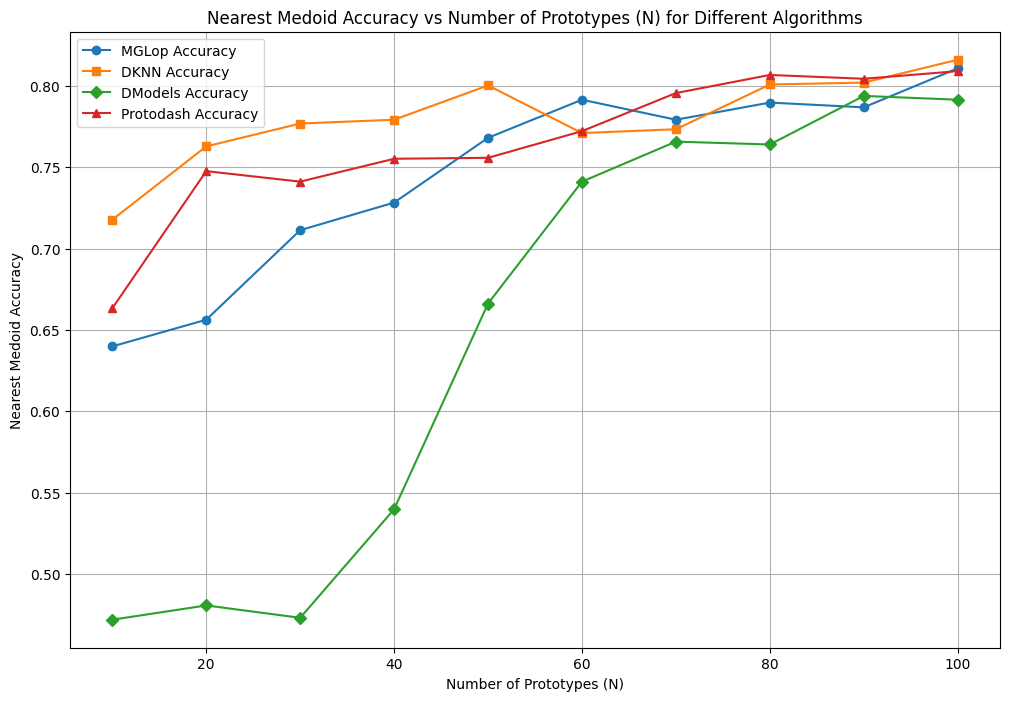

In [18]:
N_range=range(10,101,10)
plt.figure(figsize=(12, 8))
plt.plot(N_range, [item[0] for item in mglop_ev], marker='o', linestyle='-', label='MGLop Accuracy')
plt.plot(N_range, [item[0] for item in dknn_ev], marker='s', linestyle='-', label='DKNN Accuracy')
plt.plot(N_range, [item[0] for item in dmodels_ev], marker='D', linestyle='-', label='DModels Accuracy')
plt.plot(N_range, [item[0] for item in protodash_ev], marker='^', linestyle='-', label='Protodash Accuracy')

plt.xlabel("Number of Prototypes (N)")
plt.ylabel("Nearest Medoid Accuracy")
plt.title("Nearest Medoid Accuracy vs Number of Prototypes (N) for Different Algorithms")
plt.legend()
plt.grid(True)
# plt.savefig("Figures/nearest_medoid_accuracy_plot.pdf", format="pdf")
plt.show()

100%|██████████| 10/10 [00:01<00:00,  5.32it/s]


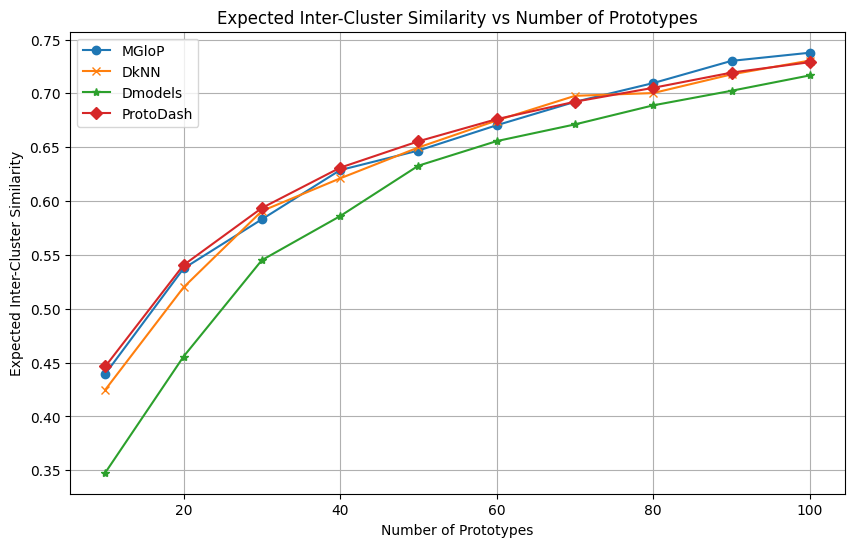

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist


# Experiment with increasing number of prototypes
num_prototypes_list = range(10, 101, 10)
avg_similarities = []
avg_similarities1 = []
avg_similarities2 = []
avg_similarities3 = []

for i in tqdm(range(10)):
    mglop=list(all_protos_np[i].values())[0]
    dmodels=list(all_protos_np[i].values())[2]
    dknn=list(all_protos_np[i].values())[1]
    protodash=list(all_protos_np[i].values())[3]
    labels = cluster_by_prototypes(X_test, mglop)
    labels1 = cluster_by_prototypes(X_test, dknn)
    labels2 = cluster_by_prototypes(X_test, dmodels)
    labels3 = cluster_by_prototypes(X_test, protodash)
    avg_similarity = expected_inter_cluster_similarity(X_test, labels)
    avg_similarity1 = expected_inter_cluster_similarity(X_test, labels1)
    avg_similarity2 = expected_inter_cluster_similarity(X_test, labels2)
    avg_similarity3 = expected_inter_cluster_similarity(X_test, labels3)
    avg_similarities.append(avg_similarity)
    avg_similarities1.append(avg_similarity1)
    avg_similarities2.append(avg_similarity2)
    avg_similarities3.append(avg_similarity3)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(num_prototypes_list, avg_similarities, marker='o', label='MGloP')
plt.plot(num_prototypes_list, avg_similarities1, marker='x', label='DkNN')
plt.plot(num_prototypes_list, avg_similarities2, marker='*', label='Dmodels')
plt.plot(num_prototypes_list, avg_similarities3, marker='D', label='ProtoDash')
plt.xlabel('Number of Prototypes')
plt.ylabel('Expected Inter-Cluster Similarity')
plt.title('Expected Inter-Cluster Similarity vs Number of Prototypes')
plt.legend()
plt.grid(True)
plt.show()